In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import Model, regularizers
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD
from sklearn.metrics import confusion_matrix,classification_report
from keras.models import Sequential


In [2]:
train_dir = 'dataset/train'
test_dir = 'dataset/test'
val_dir= 'dataset/val'

In [3]:
Image_size = 224
input_shape = (224,224,3)

def scalar(img):
    return img


tr_gen = ImageDataGenerator(preprocessing_function=scalar,
                            horizontal_flip=True,
                            vertical_flip=True)


train_gen = tr_gen.flow_from_directory(
              directory = os.path.join(train_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

test_gen = ImageDataGenerator(preprocessing_function=scalar).flow_from_directory(
              directory = os.path.join(test_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

val_gen = ImageDataGenerator(preprocessing_function=scalar).flow_from_directory(
              directory = os.path.join(val_dir),
              target_size=(Image_size,Image_size),
              batch_size =32,shuffle=True,
             class_mode='categorical')

Found 154 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Found 44 images belonging to 3 classes.


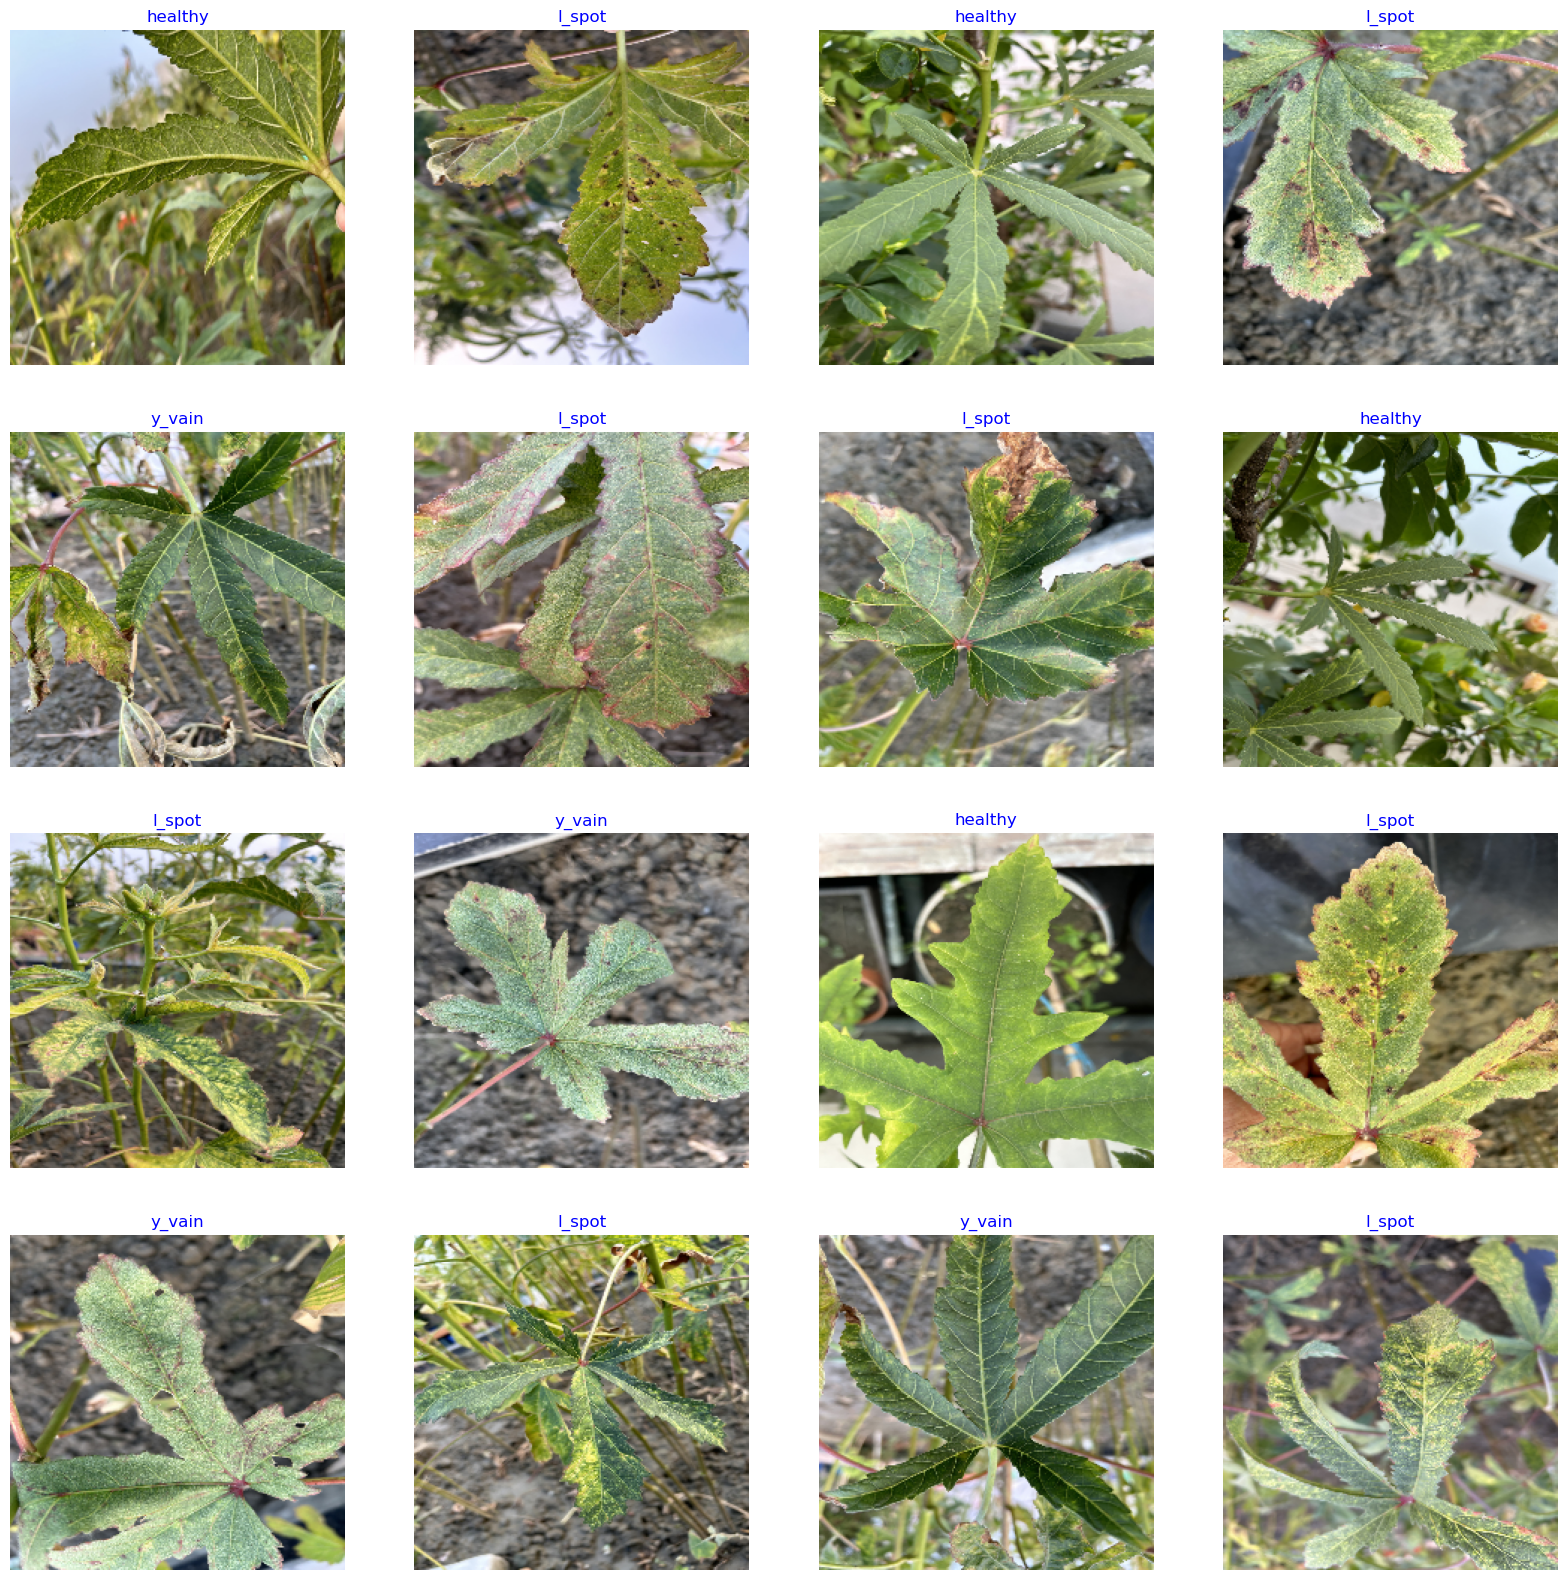

In [4]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]   /255   # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

In [5]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

for layer in base_model.layers:
    layer.trainable= False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 11,183,922
Trainable params: 397,315
Non-trainable params: 10,786,607
______________________________________

In [6]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=50,
                    verbose=True)

Epoch 1/50
5/5 [==============================] - 56s 8s/step - loss: 9.3087 - accuracy: 0.3636 - val_loss: 10.9458 - val_accuracy: 0.4318
Epoch 2/50
5/5 [==============================] - 31s 7s/step - loss: 8.3800 - accuracy: 0.7078 - val_loss: 9.6499 - val_accuracy: 0.4773
Epoch 3/50
5/5 [==============================] - 31s 6s/step - loss: 8.1324 - accuracy: 0.7532 - val_loss: 8.7799 - val_accuracy: 0.6364
Epoch 4/50
5/5 [==============================] - 30s 6s/step - loss: 7.8772 - accuracy: 0.7662 - val_loss: 8.1774 - val_accuracy: 0.7500
Epoch 5/50
5/5 [==============================] - 30s 6s/step - loss: 7.5820 - accuracy: 0.8377 - val_loss: 7.8372 - val_accuracy: 0.8409
Epoch 6/50
5/5 [==============================] - 30s 6s/step - loss: 7.4084 - accuracy: 0.8571 - val_loss: 7.5190 - val_accuracy: 0.9545
Epoch 7/50
5/5 [==============================] - 30s 6s/step - loss: 7.2498 - accuracy: 0.8961 - val_loss: 7.2786 - val_accuracy: 0.9773
Epoch 8/50
5/5 [=================

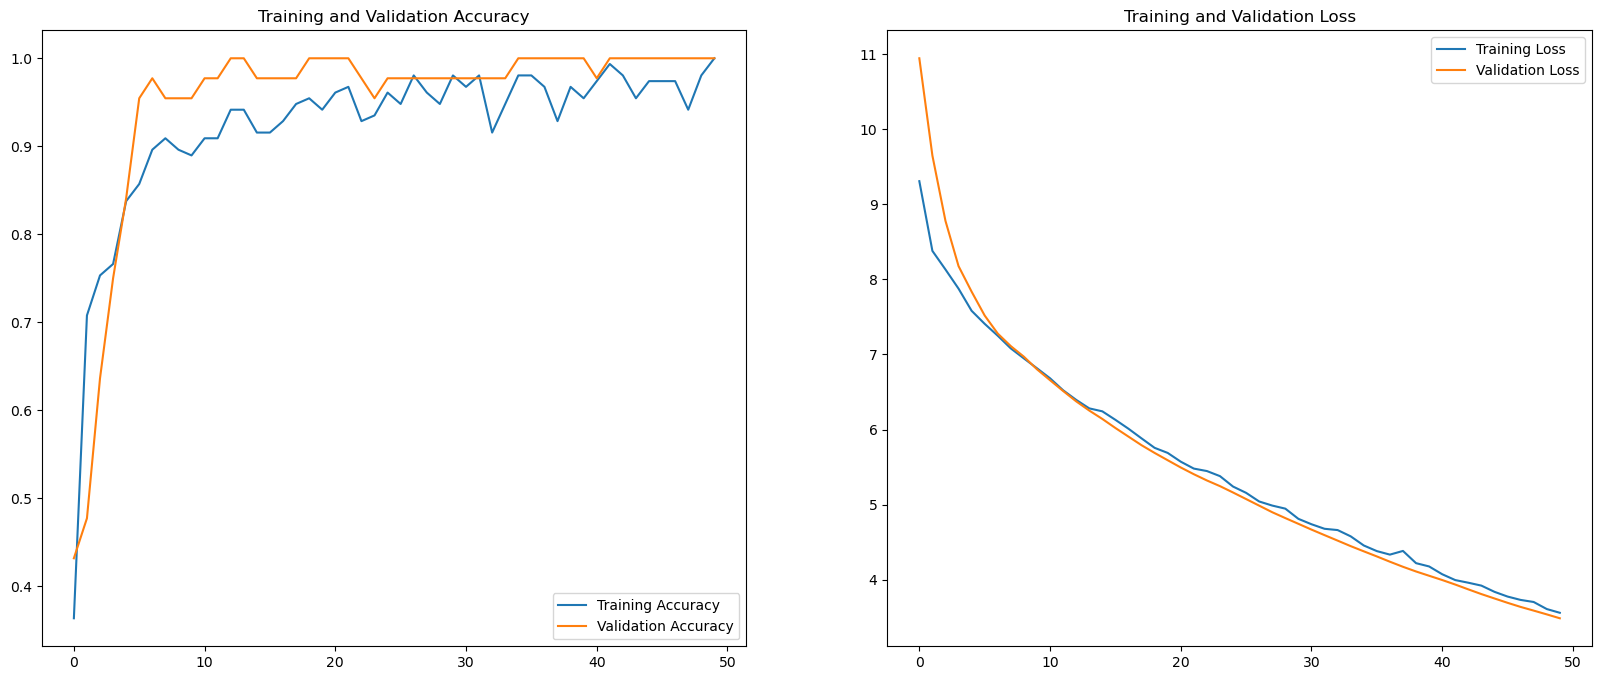

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
model.evaluate(test_gen)

1/1 [==============================] - 4s 4s/step - loss: 3.5389 - accuracy: 0.9167


[3.5389156341552734, 0.9166666865348816]

In [9]:
predictions =model.predict(test_gen)

1/1 [==============================] - 7s 7s/step


In [10]:
predictions[:5]

array([[1.5147292e-03, 9.8618442e-01, 1.2300894e-02],
       [9.8308402e-01, 3.2763137e-03, 1.3639596e-02],
       [9.1889495e-01, 1.8306747e-02, 6.2798321e-02],
       [3.4397833e-02, 7.2365797e-01, 2.4194418e-01],
       [9.9875510e-01, 2.7357574e-04, 9.7130344e-04]], dtype=float32)

In [11]:
y_test = []
y_test_int = []
for i in tqdm(range(len(test_gen))):
    y_test += test_gen[i][1].tolist()
    y_test_int += test_gen[i][1].argmax(axis=1).tolist()
y_test = np.array(y_test)
y_test_int = np.array(y_test_int)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


In [12]:
y_pred_test = model.predict(test_gen, verbose=1)
y_pred_test_int = y_pred_test.argmax(axis=1)
print(y_pred_test,y_pred_test_int)

1/1 [==============================] - 4s 4s/step
[[1.51472923e-03 9.86184418e-01 1.23008937e-02]
 [1.48434257e-02 9.62725341e-01 2.24311966e-02]
 [1.02245538e-02 9.30520415e-01 5.92550002e-02]
 [6.80457044e-04 9.98607874e-01 7.11618632e-04]
 [2.62546539e-03 1.19029998e-03 9.96184170e-01]
 [1.81367528e-02 8.79462957e-02 8.93916905e-01]
 [9.71787035e-01 3.70803545e-03 2.45049074e-02]
 [1.22556454e-02 3.04413456e-02 9.57302988e-01]
 [9.98755097e-01 2.73575744e-04 9.71303438e-04]
 [5.38582401e-03 9.93063986e-01 1.55018712e-03]
 [6.98606996e-03 5.86440042e-03 9.87149537e-01]
 [9.83084023e-01 3.27631366e-03 1.36395963e-02]
 [3.43978330e-02 7.23657966e-01 2.41944179e-01]
 [9.77937758e-01 1.48455184e-02 7.21667754e-03]
 [2.65380344e-03 2.04600813e-03 9.95300233e-01]
 [6.97070686e-03 5.88817954e-01 4.04211313e-01]
 [7.65424743e-02 1.22973517e-01 8.00483942e-01]
 [8.03583860e-01 4.90275100e-02 1.47388607e-01]
 [4.15498726e-02 3.95879209e-01 5.62570930e-01]
 [2.09923051e-02 9.68681097e-01 1.0326

              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00         7
      l_spot       0.90      0.90      0.90        10
      y_vain       0.86      0.86      0.86         7

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.92      0.92      0.92        24



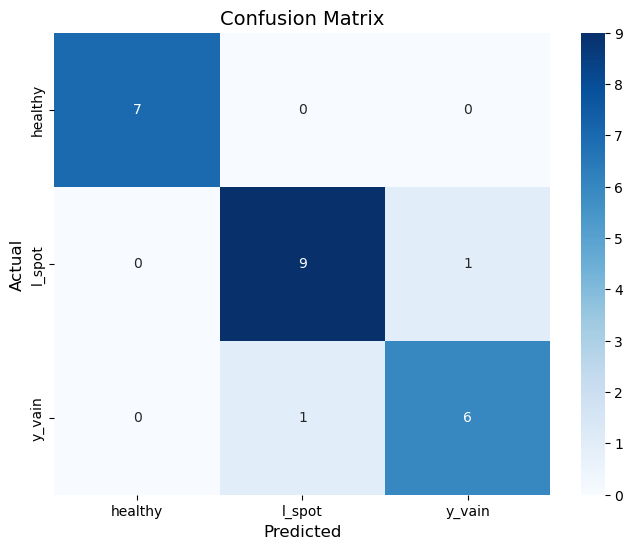

In [13]:
# Define target names
target_names = ['healthy', 'l_spot', 'y_vain']
# Print classification report
print(classification_report(y_test_int, y_pred_test_int, target_names=target_names))

# Generate confusion matrix
cm = confusion_matrix(y_test_int, y_pred_test_int)

# Plot confusion matrix using the blue colormap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()


In [14]:
model.save_weights('saved_model/effnetb3_weight.h5')